In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
DATA_FILE_PATH = "data/time_series_forecasting_data.csv"  # !!! REPLACE WITH YOUR FILE PATH !!!
TARGET_VARIABLE = 'svr1'  # Column to predict
DATETIME_COLUMN = 'datetime'
ARIMA_ORDER = (5, 1, 0) # need to tune

In [3]:
# --- 1. Load Data ---
print(f"Loading data from {DATA_FILE_PATH} for ARIMA...")
try:
    df = pd.read_csv(DATA_FILE_PATH)
except FileNotFoundError:
    print(f"ERROR: File not found at {DATA_FILE_PATH}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

print("Data loaded. Shape:", df.shape)

Loading data from data/time_series_forecasting_data.csv for ARIMA...
Data loaded. Shape: (443, 6)


In [4]:
# --- 2. Preprocessing for ARIMA ---
print("\nPreprocessing data for ARIMA...")
if DATETIME_COLUMN not in df.columns:
    print(f"ERROR: Datetime column '{DATETIME_COLUMN}' not found.")
    exit()
df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
df = df.set_index(DATETIME_COLUMN)
df = df.sort_index()

# Select only the target variable for ARIMA (univariate model)
if TARGET_VARIABLE not in df.columns:
    print(f"ERROR: Target variable '{TARGET_VARIABLE}' not found.")
    exit()
ts_data = df[TARGET_VARIABLE].dropna() # Drop NaNs in the target series

# Handle potential infinite values if any
ts_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ts_data.dropna(inplace=True)

if ts_data.empty:
    print(f"ERROR: No data left for '{TARGET_VARIABLE}' after preprocessing. Check for all NaNs or Infs.")
    exit()

print(f"Using '{TARGET_VARIABLE}' series. Length: {len(ts_data)}")


Preprocessing data for ARIMA...
Using 'svr1' series. Length: 443


In [5]:
# --- 3. Data Splitting ---
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

if len(train) < ARIMA_ORDER[0] + ARIMA_ORDER[1] + 2 or len(test) == 0: # Basic check for sufficient data
     print("ERROR: Not enough data for training or testing with the given ARIMA order.")
     exit()

Train size: 354, Test size: 89


In [6]:
# --- 4. Model Training ---
print(f"\nTraining ARIMA model with order {ARIMA_ORDER}...")
try:
    model = ARIMA(train, order=ARIMA_ORDER)
    model_fit = model.fit()
    print(model_fit.summary())
    print("ARIMA model training complete.")
except Exception as e:
    print(f"Error training ARIMA model: {e}")
    print("This might be due to non-stationarity, inappropriate (p,d,q) orders, or data issues.")
    exit()


Training ARIMA model with order (5, 1, 0)...


c:\Users\thmng\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\thmng\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\thmng\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   svr1   No. Observations:                  354
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1983.005
Date:                Wed, 07 May 2025   AIC                           3978.010
Time:                        21:09:37   BIC                           4001.209
Sample:                    07-04-2022   HQIC                          3987.241
                         - 07-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.035     -7.514      0.000      -0.335      -0.197
ar.L2         -0.0980      0.048     -2.021      0.043      -0.193      -0.003
ar.L3          0.0070      0.057      0.124      0.9

In [7]:
# --- 5. Make Predictions ---
print("\nMaking predictions on the test set...")
# predictions = model_fit.predict(start=len(train), end=len(ts_data)-1, dynamic=False)
# A more robust way to get predictions corresponding to the test set:
predictions = model_fit.forecast(steps=len(test))
predictions.index = test.index # Align index for comparison


Making predictions on the test set...


In [8]:
# --- 6. Evaluate the Model ---
print("\nEvaluating ARIMA model performance...")
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

print(f"  Test Set RMSE: {rmse:.4f}")
print(f"  Test Set MAE: {mae:.4f}")
print(f"  Mean of target variable in test set ({TARGET_VARIABLE}): {test.mean():.4f}")


Evaluating ARIMA model performance...
  Test Set RMSE: 154.4498
  Test Set MAE: 105.4600
  Mean of target variable in test set (svr1): 137.6224


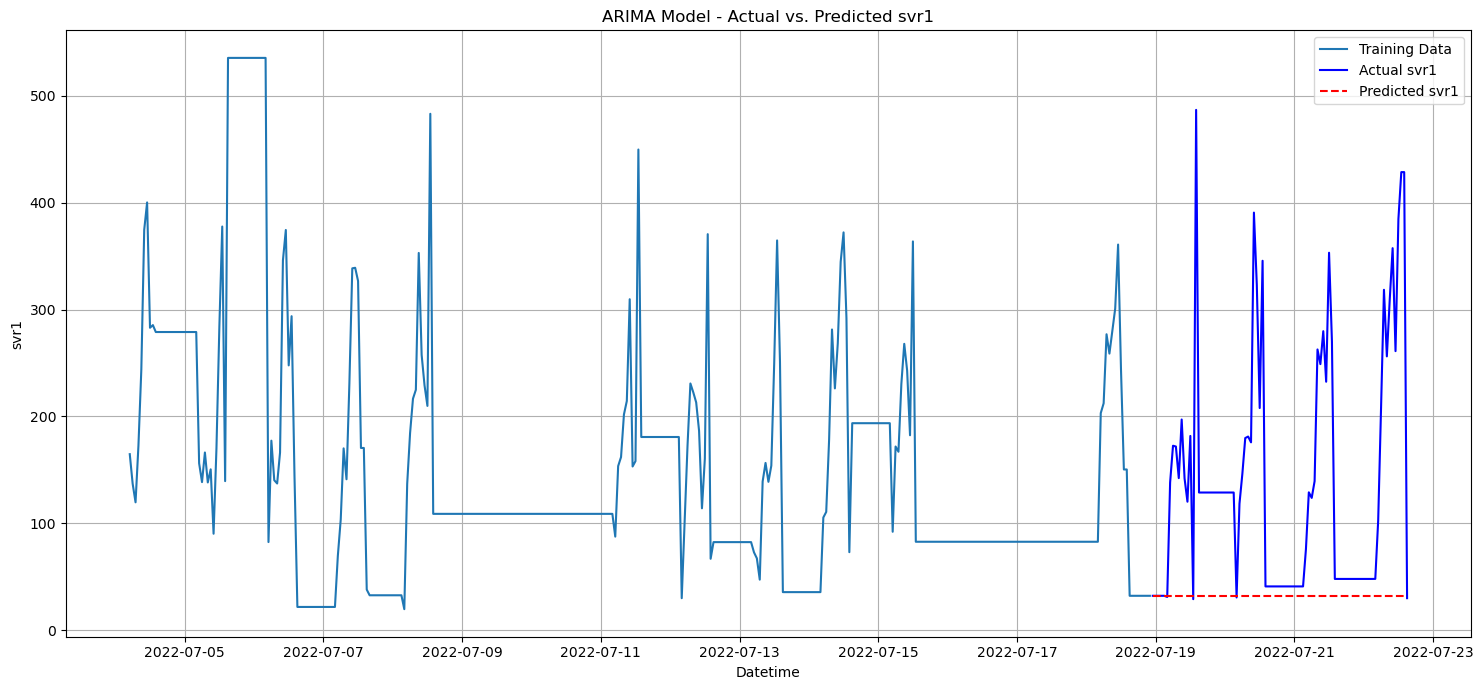

In [9]:
# --- 7. Plotting Predictions vs Actuals ---
plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual ' + TARGET_VARIABLE, color='blue')
plt.plot(predictions.index, predictions, label='Predicted ' + TARGET_VARIABLE, color='red', linestyle='--')
plt.title(f'ARIMA Model - Actual vs. Predicted {TARGET_VARIABLE}')
plt.xlabel('Datetime')
plt.ylabel(TARGET_VARIABLE)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()